In [1]:
# Importerer pakker:
from diabetesmodel import MVPmodel
from fitting import *
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

# About the implementation
The models are implemented through a class "MVPmodel", which is defined in the diabetesmodel.py file.

Objects of this class have some different attributes. Including initial values for the state, parameters for the simulation, tuning parameters, etc. 
The default values can be read and modified in the "config.json" file.

Defaults can be overridden through keyword arguments upon initialisation of the objects. 

In [2]:
patient1 = MVPmodel() # Object with default values.
patient2 = MVPmodel(G = 120) # Object where G is initialised to be 120.
print("Different attributes and their defaults:")
pprint(patient1.__dict__)

Different attributes and their defaults:
{'C1': 20.1,
 'D1': 0,
 'D2': 0,
 'G': 108,
 'Gbar': 108,
 'Gmin': 70,
 'Gsc': 108,
 'Ieff': 0.0101028358,
 'Ip': 1.24726368,
 'Isc': 1.24726368,
 'Kp': 0.25,
 'S1': 0.0081,
 'Td': 15,
 'Ti': 500,
 'Vg': 253,
 'egp0': 1.33,
 'gezi': 0.0022,
 'kappa': 10000000.0,
 'p2': 0.0106,
 'tau1': 49,
 'tau2': 47,
 'taum': 47,
 'tausc': 5,
 'us': 25.1,
 'x': [0, 0, 1.24726368, 1.24726368, 0.0101028358, 108, 108],
 'x0': [0, 0, 1.24726368, 1.24726368, 0.0101028358, 108, 108]}


The value of the attributes can also be changed afterwards. Note that the "start state", x0, is defined upon initialisation.

In [3]:
print(f"Object's 'G' value upon initialisation: {patient1.G}")
patient1.G = 130
print(f"Changed to: {patient1.G}")
patient1.reset()
print(f"After reset: {patient1.G}")

Object's 'G' value upon initialisation: 108
Changed to: 130
After reset: 108


# Simulations with given insulin injection rate
You can simulate a patient's state from their insulin injection rate and their carb ingestion rate, using the "simulate" method.

The simulate method has the input parameter "u_func", which, if given, can either be an array, a number, or "PID".
If unspecified, the injection rate will default to the object's "us" attribute (steady state insulin).

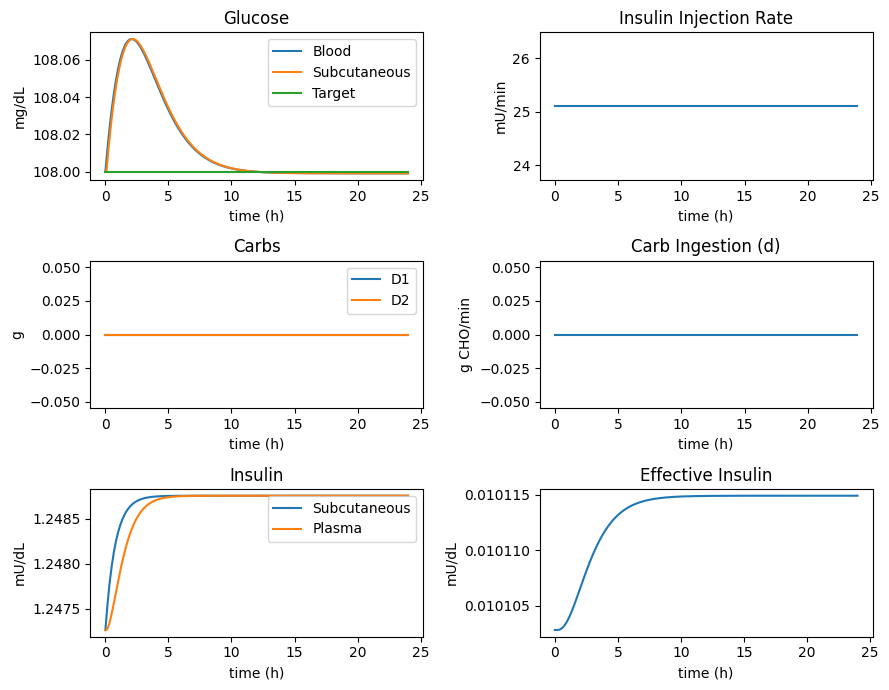

In [4]:
patient1.reset()
n = (24 * 60)//patient1.tausc # Number of timesteps for a 24h simulation. The parameter "tausc" is the length of a timestep in minutes. 

d_list = np.zeros(n) # No carbs

states, u_list = patient1.simulate(d_list) # Runs simulation. Returns a matrix containing the state during simulation, and a list of injection rates.
patient1.plot(states, u_list, d_list) #  Plotting

# Simulations with PID-controller
Using the simulate method, with u_func as "PID", you can run simulations where the insulin injection rate is administrated by a PID-controller.

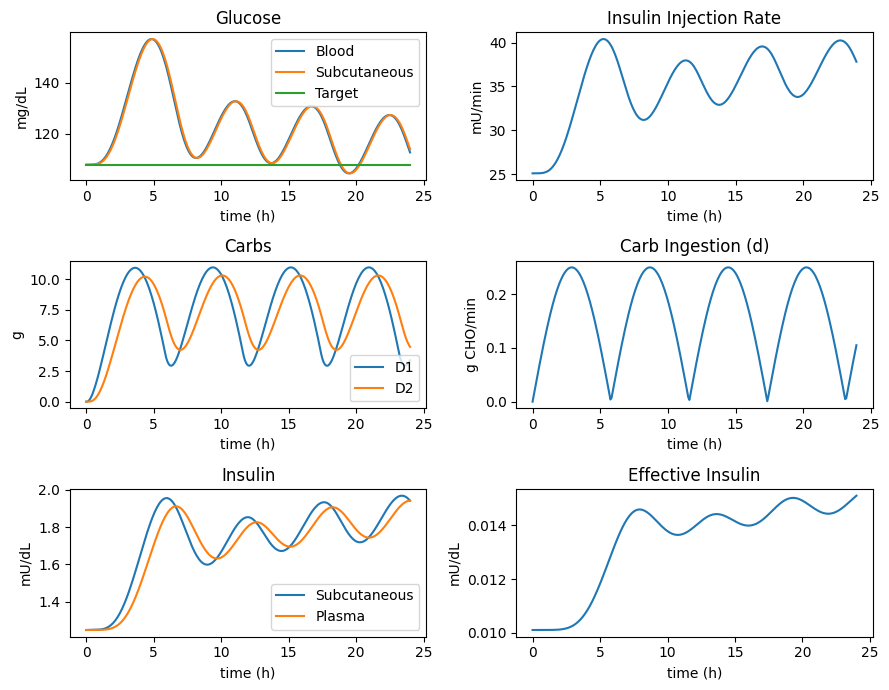

In [5]:
patient1.reset()
d = np.abs(np.sin(np.linspace(0,13,n))) / 4 # Funky eating patterns
states, u = patient1.simulate(d, u_func="PID")
patient1.plot(states, u, d)

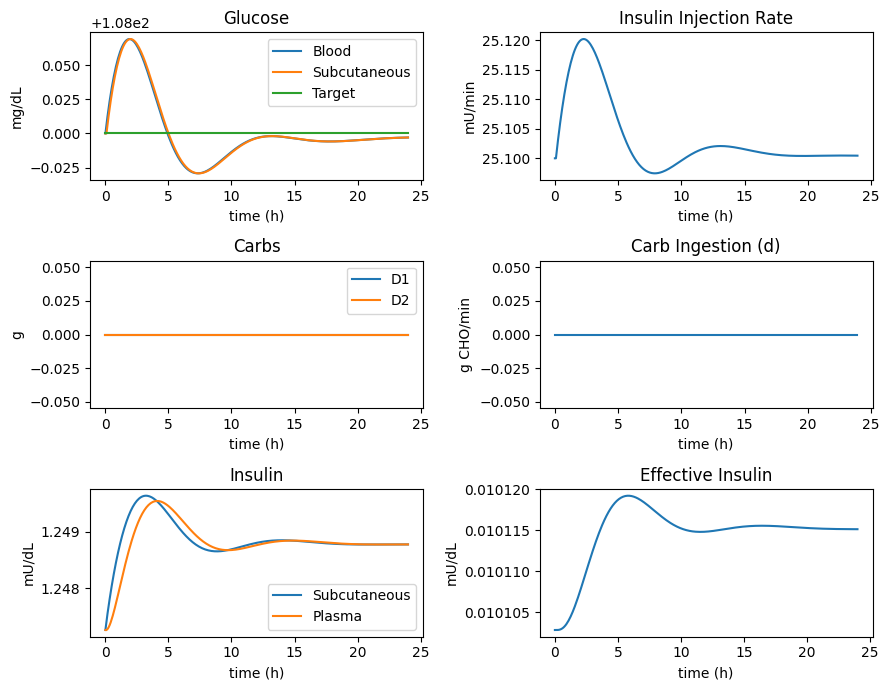

In [6]:
patient1.reset()
d = np.zeros(n)
states, u = patient1.simulate(d, u_func="PID")
patient1.plot(states, u, d)

# Bolus size
Given an insulin bolus size (measured in "U") and the number of carbs in a meal, "bolus_sim" simulates the patient's state, and returns the integral of the penalty function, the values of the penalty function, and the blood glucose in every time step.

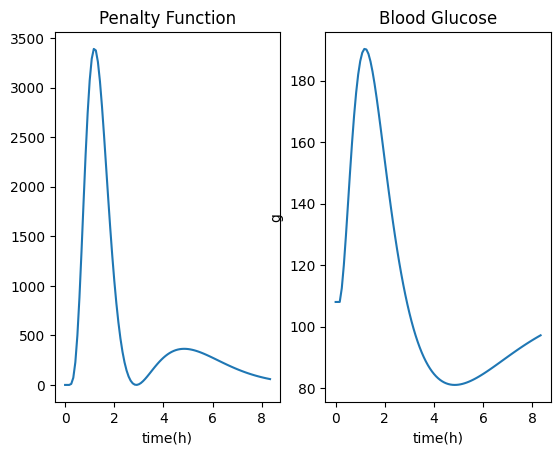

In [7]:
patient1.reset()
phi, p, Gt = patient1.bolus_sim(8, 100, 0, plot=True) # Bolus of 10 U, and meal of 75 g carbs.

You can iterate through these simulations with the "optimal_bolus" method, which generates a (very boring looking) heatplot, where the colour of each pixel indicates the integral of the penalty function. The minimum values are indicated with red.

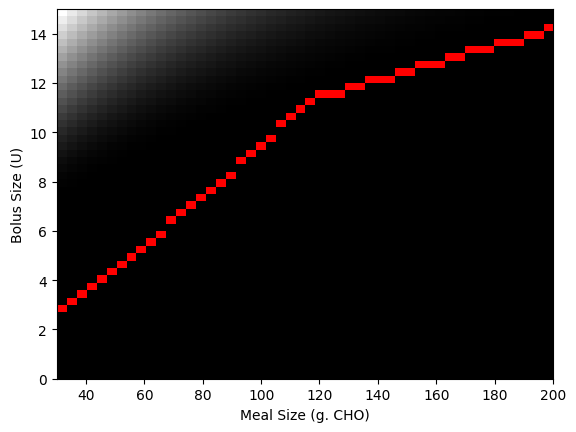

In [8]:
patient1.reset()

meals, best_us = patient1.optimal_bolus(meal_idx = 0, min_U = 0, max_U = 15, max_meal = 200, n = 50)

A piecewise linear fit can be fitted to the data, using the "piecewise_linear_fit", from "fitting.py".

In [9]:
_, fun, _ = piecewise_linear_fit(meals, best_us)

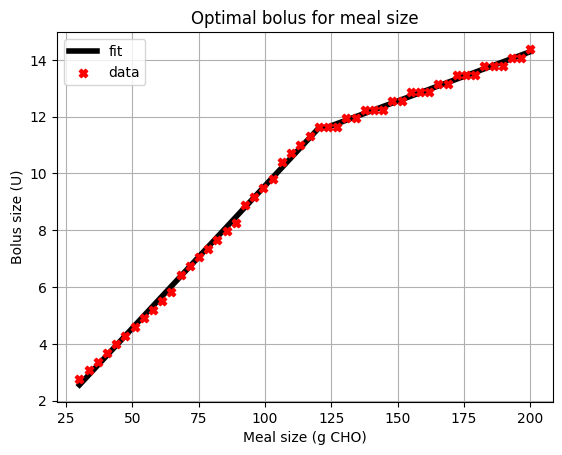

In [10]:
plt.plot(meals, fun(meals), linewidth=4, color="black",label="fit")
plt.scatter(meals, best_us, color="red", zorder=2, marker="X", label="data")
plt.grid("gray")
plt.legend()
plt.title("Optimal bolus for meal size")
plt.xlabel("Meal size (g CHO)")
plt.ylabel("Bolus size (U)");